# Test: Data Owner (Client1) - SyftBox Mode

Automated test notebook for the Data Owner workflow with SyftBox encryption.
Run with: `jupyter execute sc_test_do.ipynb`

In [1]:
!pip install -q --force-reinstall --no-deps $(ls -t ../../syftbox-sdk/python/target/wheels/syftbox_sdk-*arm64.whl | head -1)
!pip install -e ../../python --upgrade -q --upgrade

In [2]:
# !pip install -q --force-reinstall ../../syftbox-sdk/python/target/wheels/*.whl

In [3]:
import sys
from pathlib import Path

# Configuration
TIMEOUT = 120.0
USER_EMAIL = "client1@sandbox.local"
PEER_EMAIL = "client2@sandbox.local"
DATA_DIR = Path.cwd()

In [4]:
!uv pip install scanpy

Audited 1 package in 44ms


In [5]:
import scanpy as sc
import anndata as ad
from beaver import Twin
from beaver.runtime import TrustedLoader
import beaver

# Connect with SyftBox backend
bv = beaver.connect(
    user=USER_EMAIL,
    data_dir=DATA_DIR,
)
print(f"[DO] Connected as {bv.user}")
print(f"[DO] SyftBox enabled: {bv.syftbox_enabled}")

🔄 Auto-load replies enabled for client1@sandbox.local (polling every 2.0s)
[DO] Connected as client1@sandbox.local
[DO] SyftBox enabled: True
✨ Auto-loaded reply: make_violin_result = Twin
   From: client1@sandbox.local
   Reply to: b5f3a1c0...


In [6]:
# Register AnnData serialization
@TrustedLoader.register(ad.AnnData)
def anndata_serialize_file(obj, path):
    obj.write_h5ad(path)

@TrustedLoader.register(ad.AnnData)
def anndata_deserialize_file(path):
    return ad.read_h5ad(path)

print("[DO] Registered AnnData loader")

[DO] Registered AnnData loader


In [7]:
# Wait for session request from DS
import time

print("[DO] Waiting for session request from DS...")
session = None
deadline = time.monotonic() + TIMEOUT

while time.monotonic() < deadline:
    requests = bv.session_requests()
    if len(requests) > 0:
        # Accept the first request
        session = requests[0].accept()
        print(f"[DO] Accepted session from {requests[0].requester}")
        print(f"[DO] Session ID: {session.session_id}")
        break
    time.sleep(1.0)

assert session is not None, "Timeout waiting for session request"

[DO] Waiting for session request from DS...
✅ Session accepted: 6cac1bf2ba65
   Peer: client2@sandbox.local
   Session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/6cac1bf2ba65
[DO] Accepted session from client2@sandbox.local
[DO] Session ID: 6cac1bf2ba65


In [8]:
# Load single-cell data
data_dir = Path("single_cell/data")
private_path = data_dir / "sc_RNAseq_adata_downsampled_to5percent.private.h5ad"
mock_path = data_dir / "sc_RNAseq_adata_downsampled_to5percent.mock.h5ad"
sim_path = data_dir / "adata_simulated.h5ad"

# Create mock from simulated if needed
if not mock_path.exists() and sim_path.exists():
    print("[DO] Creating mock data from simulated...")
    adata_sim = sc.read(sim_path)
    adata_sim.obs.rename(columns={"pct_counts_in_top_50_genes": "pct_counts_mt"}, inplace=True)
    adata_sim.obs.rename(columns={"group": "cell_type"}, inplace=True)
    adata_sim.write_h5ad(mock_path)

adata_private = sc.read(private_path)
adata_mock = sc.read(mock_path)

print(f"[DO] Loaded private: {adata_private.n_obs} cells")
print(f"[DO] Loaded mock: {adata_mock.n_obs} cells")

assert adata_private.n_obs > 0, "Private data is empty"
assert adata_mock.n_obs > 0, "Mock data is empty"

[DO] Loaded private: 7876 cells
[DO] Loaded mock: 30000 cells


In [9]:
# Create and publish Twin to session
patient_sc = Twin(
    private=adata_private,
    public=adata_mock,
    owner=USER_EMAIL,
    name="patient_sc",
)

# Publish to session (encrypted for peer only)
session.remote_vars["patient_sc"] = patient_sc
print("[DO] Published patient_sc Twin to session")

# Track processed requests
processed_requests = set()

🌍 Using PUBLIC data from Twin 'patient_sc...'
📢 Published Twin 'patient_sc' (public side available at: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/6cac1bf2ba65/data/5d8cc1b8859645a690a8de544c61cd1b.beaver)
[DO] Published patient_sc Twin to session


In [10]:
# Request 1: Violin plot
print("[DO] Waiting for request 1/4 (violin)...")
bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)

[DO] Waiting for request 1/4 (violin)...
📬 New message: request_make_violin_for_violin_result
   From: client2@sandbox.local


(BeaverEnvelope [CODE]: request_make_violin_for_violin_result
   From: client2@sandbox.local
   Type: ComputationRequest (__main__)
   Size: 874 bytes
   Created: 2025-12-01 06:42:42 UTC
   ID: 0f13341f...
 
 Arguments (1):
   [0] dict: {'_beaver_twin_ref': True, 'twin_id': '6ab7488438304c3088...
       📌 Static value (bound at call time)
 
 Signature: request_make_violin_for_violin_result(adata)
 
 Source:
   def make_violin(adata):
       print("n_cells:", adata.n_obs)
       sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], size=0, multi_panel=True)
       return plt.gcf(),
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 ⚡ Action: make_violin_result
    Request from: client2@sandbox.local
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 
 📋 Function: make_violin
 
 ⚙️  Static Parameters:
   • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '6ab74884...
 
 💡 Next Steps:
    .run_mock()   → Test on mock/pu

In [11]:
session

🟢 Session(
    id='6cac1bf2ba65',
    peer='client2@sandbox.local',
    role='accepter',
    status='active'
)

In [12]:
session.inbox()

name,id,sender,type,size_bytes,created_at,reply_to
request_make_violin_for_violin_result,0f13341fe9ed...,client2@sandbox.local,ComputationRequest,874,2025-12-01 06:42:42,


In [13]:
bv.inbox()

name,id,sender,type,size_bytes,created_at,reply_to
make_violin_result,b4116ec2c03a...,client1@sandbox.local,Twin,373,2025-12-01 06:19:12,b5f3a1c00864...
request_make_violin_for_violin_result,0f13341fe9ed...,client2@sandbox.local,ComputationRequest,874,2025-12-01 06:42:42,


In [14]:
bv.inbox()

name,id,sender,type,size_bytes,created_at,reply_to
make_violin_result,b4116ec2c03a...,client1@sandbox.local,Twin,373,2025-12-01 06:19:12,b5f3a1c00864...
request_make_violin_for_violin_result,0f13341fe9ed...,client2@sandbox.local,ComputationRequest,874,2025-12-01 06:42:42,


In [15]:
bv.inbox()[1].load()

✓ Loaded 'request_make_violin_for_violin_result' into globals


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: make_violin_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: make_violin

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '6ab74884...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=a73b88a49063... result=04ae0fb478ff...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [16]:
request_make_violin_for_violin_result

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: make_violin_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: make_violin

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '6ab74884...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=a73b88a49063... result=04ae0fb478ff...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [17]:
patient_sc

⚠️  Twin: patient_sc (REAL + MOCK DATA)
  ⚠️  Be careful: This Twin contains both real and mock data
  🔒 Private    AnnData n_obs=7876, n_vars=27361    ← .value uses this
  🌍 Public    AnnData n_obs=30000, n_vars=36601    ✓
  Live: ⚫ Disabled
  IDs: twin=6ab74884... private=4080face... public=2a0f21db...

n_cells: 7876


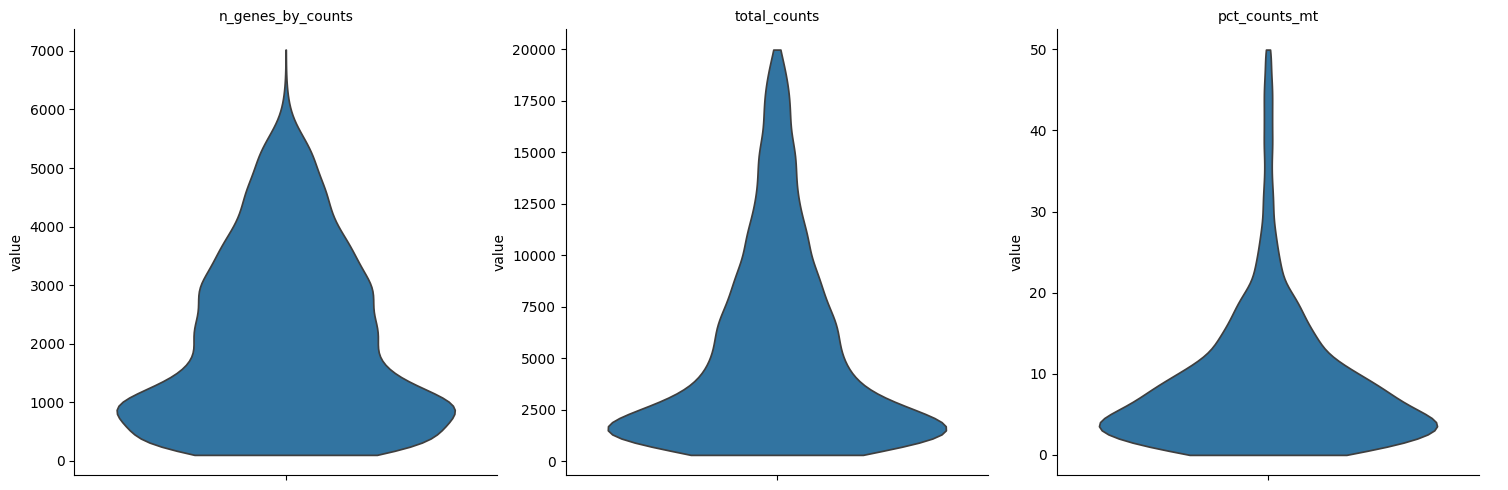

<Figure size 640x480 with 0 Axes>

In [18]:
res = request_make_violin_for_violin_result.func(patient_sc.private)

In [19]:
# Find the first unprocessed computation request in inbox
inbox = bv.inbox()
request_envs = [e for e in inbox if e.name and e.name.startswith("request_") and e.name not in processed_requests]
assert len(request_envs) > 0, "No new request found in inbox"
request_env = request_envs[0]
print(f"[DO] Received: {request_env.name}")

# Load it - this injects the request into globals
request_env.load()
processed_requests.add(request_env.name)

# The loaded variable name is the envelope name
request_obj = globals()[request_env.name]
print(f"[DO] Running: {request_env.name}")

result = request_obj.run_both()
assert result is not None, "run_both() returned None"

result.approve()
print("[DO] ✓ Request 1 complete")

[DO] Received: request_make_violin_for_violin_result
✓ Loaded 'request_make_violin_for_violin_result' into globals
[DO] Running: request_make_violin_for_violin_result
🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
⚠️  Mock execution failed: 'dict' object has no attribute 'n_obs'
🔒 Step 2/2: Executing on real/private data...
✓ Private result: NoneType
✅ Approving result for: make_violin_result
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'make_violin_result...'
✓ Result sent to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/6cac1bf2ba65
💡 They can load it with: bv.inbox()['make_violin_result'].load()
[DO] ✓ Request 1 complete


In [20]:
result = request_obj.run_mock()

🧪 Testing on mock/public data...
⚠️  Mock execution failed: 'dict' object has no attribute 'n_obs'


In [21]:
# Request 2: Embedding
print("[DO] Waiting for request 2/4 (embedding)...")
bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)

inbox = bv.inbox()
request_envs = [e for e in inbox if e.name and e.name.startswith("request_") and e.name not in processed_requests]
assert len(request_envs) > 0, "No new request found in inbox"
request_env = request_envs[0]
print(f"[DO] Received: {request_env.name}")

request_env.load()
processed_requests.add(request_env.name)
request_obj = globals()[request_env.name]
print(f"[DO] Running: {request_env.name}")

result = request_obj.run_both()
assert result is not None, "run_both() returned None"

result.approve()
print("[DO] ✓ Request 2 complete")

[DO] Waiting for request 2/4 (embedding)...
📬 New message: request_show_embedding_for_embedding_result
   From: client2@sandbox.local
[DO] Received: request_show_embedding_for_embedding_result
✓ Loaded 'request_show_embedding_for_embedding_result' into globals
[DO] Running: request_show_embedding_for_embedding_result
🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
⚠️  Mock execution failed: 'dict' object has no attribute 'n_obs'
🔒 Step 2/2: Executing on real/private data...
✓ Private result: NoneType
✅ Approving result for: show_embedding_result
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'show_embedding_result...'
✓ Result sent to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/6cac1bf2ba65
💡 They can load it with: bv.inbox()['show_embedding_result'].load()
[DO] ✓ Request 2 complete


In [22]:
# Request 3: PCA variance
print("[DO] Waiting for request 3/4 (pca)...")
bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)

inbox = bv.inbox()
request_envs = [e for e in inbox if e.name and e.name.startswith("request_") and e.name not in processed_requests]
assert len(request_envs) > 0, "No new request found in inbox"
request_env = request_envs[0]
print(f"[DO] Received: {request_env.name}")

request_env.load()
processed_requests.add(request_env.name)
request_obj = globals()[request_env.name]
print(f"[DO] Running: {request_env.name}")

result = request_obj.run_both()
assert result is not None, "run_both() returned None"

result.approve()
print("[DO] ✓ Request 3 complete")

[DO] Waiting for request 3/4 (pca)...
📬 New message: request_plot_pca_variance_for_pca_result
   From: client2@sandbox.local
[DO] Received: request_plot_pca_variance_for_pca_result
✓ Loaded 'request_plot_pca_variance_for_pca_result' into globals
[DO] Running: request_plot_pca_variance_for_pca_result
🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
⚠️  Mock execution failed: 'dict' object has no attribute 'X'
🔒 Step 2/2: Executing on real/private data...
✓ Private result: NoneType
✅ Approving result for: plot_pca_variance_result
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'plot_pca_variance_result...'
✓ Result sent to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/6cac1bf2ba65
💡 They can load it with: bv.inbox()['plot_pca_variance_result'].load()
[DO] ✓ Request 3 complete


In [23]:
# Request 4: UMAP
print("[DO] Waiting for request 4/4 (umap)...")
bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)

inbox = bv.inbox()
request_envs = [e for e in inbox if e.name and e.name.startswith("request_") and e.name not in processed_requests]
assert len(request_envs) > 0, "No new request found in inbox"
request_env = request_envs[0]
print(f"[DO] Received: {request_env.name}")

request_env.load()
processed_requests.add(request_env.name)
request_obj = globals()[request_env.name]
print(f"[DO] Running: {request_env.name}")

result = request_obj.run_both()
assert result is not None, "run_both() returned None"

result.approve()
print("[DO] ✓ Request 4 complete")

[DO] Waiting for request 4/4 (umap)...
📬 New message: request_umap_embedding_for_umap_result
   From: client2@sandbox.local
[DO] Received: request_umap_embedding_for_umap_result
✓ Loaded 'request_umap_embedding_for_umap_result' into globals
[DO] Running: request_umap_embedding_for_umap_result
🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
⚠️  Mock execution failed: 'dict' object has no attribute 'is_view'
🔒 Step 2/2: Executing on real/private data...
✓ Private result: NoneType
✅ Approving result for: umap_embedding_result
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'umap_embedding_result...'
✓ Result sent to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/6cac1bf2ba65
💡 They can load it with: bv.inbox()['umap_embedding_result'].load()
[DO] ✓ Request 4 complete


In [24]:
# Final assertions
print("\n" + "="*50)
print("[DO] TEST PASSED")
print("[DO] Successfully handled 4 computation requests")
print("="*50)


[DO] TEST PASSED
[DO] Successfully handled 4 computation requests
